In [19]:
library(tidyverse)
if (!require("gtools")) {
    install.packages("gtools")
    library("gtools")
}
if (!require("rpart")) {
    install.packages("rpart")
    library("rpart")
}
if (!require("caret")) {
    install.packages("caret")
    library("caret")
}

In [20]:
options(repr.matrix.max.cols=64, repr.matrix.max.rows=30)

## load data

In [21]:
data_dir <- "/data/"

In [22]:
city_facilities <- read_csv(paste0(data_dir, "city_facilities.csv"))
head(city_facilities)

Rows: 80 Columns: 15

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): common_name, address, city, block_lot, owned_leased, jurisdiction
dbl (8): facility_id, zip_code, dept_id_for_jurisdiction, gross_sq_ft, longi...
lgl (1): city_tenants


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



facility_id,common_name,address,city,zip_code,block_lot,owned_leased,dept_id_for_jurisdiction,jurisdiction,gross_sq_ft,longitude,latitude,supervisor_district,city_tenants,land_id
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>
697,Fire Station #15,1000 Ocean Ave,San Francisco,94112,3180001,Own,38,Fire Department,12138,-122.4529,37.72349,7,NA,588
2,Hamilton Family Residence,260 Golden Gate Ave,San Francisco,94102,0345007,Own,45,Police Department,50000,-122.4150,37.78201,6,NA,332
685,Fire Chief's Residence,870 Bush St,San Francisco,94108,0274010,Own,38,Fire Department,4500,-122.4116,37.79000,3,NA,333
3269,Palo Alto/Marview Comm Facility,Palo Alto Ave and Marview Way,San Francisco,94114,2719C023,Own,38,Fire Department,NA,-122.4498,37.75666,7,NA,52
707,Fire Station #24,100 Hoffman Ave,San Francisco,94114,2801001,Own,38,Fire Department,7600,-122.4411,37.75313,8,NA,340
723,Fire Station #40,2155 18th Ave,San Francisco,94116,2199003,Own,38,Fire Department,7350,-122.4753,37.74761,7,NA,318


In [23]:
incident_data <- read_csv(paste0(data_dir, "fire_incidents.csv"))
head(incident_data)

Rows: 566251 Columns: 64

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (38): ID, Address, Call Number, City, zipcode, Battalion, Station Area,...
dbl  (19): Exposure Number, Suppression Units, Suppression Personnel, EMS Un...
dttm  (4): Incident Date, Alarm DtTm, Arrival DtTm, Close DtTm


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



Incident Number,Exposure Number,ID,Address,Incident Date,Call Number,Alarm DtTm,Arrival DtTm,Close DtTm,City,zipcode,Battalion,Station Area,Box,Suppression Units,Suppression Personnel,EMS Units,EMS Personnel,Other Units,Other Personnel,First Unit On Scene,Estimated Property Loss,Estimated Contents Loss,Fire Fatalities,Fire Injuries,Civilian Fatalities,Civilian Injuries,Number of Alarms,Primary Situation,Mutual Aid,Action Taken Primary,Action Taken Secondary,Action Taken Other,Detector Alerted Occupants,Property Use,Area of Fire Origin,Ignition Cause,Ignition Factor Primary,Ignition Factor Secondary,Heat Source,Item First Ignited,Human Factors Associated with Ignition,Structure Type,Structure Status,Floor of Fire Origin,Fire Spread,No Flame Spead,Number of floors with minimum damage,Number of floors with significant damage,Number of floors with heavy damage,Number of floors with extreme damage,Detectors Present,Detector Type,Detector Operation,Detector Effectiveness,Detector Failure Reason,Automatic Extinguishing System Present,Automatic Extinguishing Sytem Type,Automatic Extinguishing Sytem Perfomance,Automatic Extinguishing Sytem Failure Reason,Number of Sprinkler Heads Operating,Supervisor District,neighborhood_district,point
<dbl>,<dbl>,<chr>,<chr>,<dttm>,<chr>,<dttm>,<dttm>,<dttm>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
8028304,0,080283040,150 Elsie St.,2008-04-01,080920257,2008-04-01 18:06:37,2008-04-01 18:15:19,2008-04-01 18:21:48,SF,94110,B06,11,NA,1,4,0,0,0,0,E11,NA,NA,0,0,0,0,1,412 - Gas leak (natural gas or LPG),None,86 - Investigate,-,-,-,"962 - Residential street, road or residential dr",NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,9,Bernal Heights,POINT (-122.41837339 37.74208979)
8028303,0,080283030,85 Turner Tr.,2008-04-01,080920256,2008-04-01 18:00:52,2008-04-01 18:06:30,2008-04-01 18:22:18,SF,94107,B10,37,NA,1,4,0,0,0,0,E37,NA,NA,0,0,0,0,1,552 - Police matter,None,76 - Provide water,-,-,-,"960 - Street, other",NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,10,Potrero Hill,POINT (-122.39489 37.756291)
8028309,0,080283090,175 6th St.,2008-04-01,080920262,2008-04-01 18:42:06,2008-04-01 18:45:23,2008-04-01 18:53:25,SF,94105,B03,01,NA,10,35,0,0,0,0,E01,NA,NA,0,0,0,0,1,"210 - Steam Rupture, steam, other",None,86 - Investigate,-,-,-,429 - Multifamily dwellings,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,South of Market,POINT (-122.407468 37.78008)
8028314,0,080283140,633 Hayes St.,2008-04-01,080920268,2008-04-01 19:03:52,2008-04-01 19:08:39,2008-04-01 19:35:36,SF,94102,B02,36,NA,1,4,0,0,0,0,E36,NA,NA,0,0,0,0,1,522 - Water or steam leak,None,64 - Shut down system,-,-,-,"400 - Residential, other",NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,5,Hayes Valley,POINT (-122.42684908 37.77612642)
8028319,0,080283190,27th Av. / Cabrillo St.,2008-04-01,080920273,2008-04-01 19:16:12,2008-04-01 19:23:48,2008-04-01 19:28:49,SF,94121,B07,14,NA,1,4,0,0,0,0,E14,NA,NA,0,0,0,0,1,"520 - Water problem, other",None,"00 - Action taken, other",-,-,-,"960 - Street, other",NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Outer Richmond,POINT (-122.4863941 37.77428492)
8028337,0,080283370,165 Belgrave Av.,2008-04-01,080920294,2008-04-01 20:25:00,2008-04-01 20:31:41,2008-04-01 20:51:22,SF,94117,B05,12,NA,3,10,0,0,0,0,E12,NA,NA,0,0,0,0,1,733 - Smoke detector activation/malfunction,None,86 - Investigate,-,-,-,"400 - Residential, other",NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Inner Sunset,POINT (-122.4481912 37.7597267)


In [24]:
incident_nearest <- read_csv("/data//incident_nearest_distances.csv") %>%
    select(-`...1`)

head(incident_nearest)

New names:
* `` -> ...1

Rows: 566251 Columns: 6

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (5): ...1, ID, lon, lat, nearest_station


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



Incident Number,ID,lon,lat,nearest_station
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
8028304,80283040,-122.4184,37.74209,0.006407636
8028303,80283030,-122.3949,37.75629,0.004497294
8028309,80283090,-122.4075,37.78008,0.003405401
8028314,80283140,-122.4268,37.77613,0.005762852
8028319,80283190,-122.4864,37.77428,0.004719455
8028337,80283370,-122.4482,37.75973,0.005760260


In [25]:
incident_data.clean <- incident_data %>%
  filter(`Incident Date` > lubridate::as_date("2016-01-01")) %>%
  mutate(
    time_to_first_arrive = difftime(`Arrival DtTm`, `Alarm DtTm`, units="min"),
    time_to_last_leave = difftime(`Close DtTm`, `Alarm DtTm`, units="min"),
    supervisor_district = as.factor(`Supervisor District`),
    primary_situation = as.factor(`Primary Situation`),
    neighborhood_district = as.factor(neighborhood_district),
  ) %>%
  select(incident_id = `Incident Number`,
         ID,
         time_to_first_arrive,
         time_to_last_leave,
         supervisor_district,
         neighborhood_district,
         primary_situation,
         est_property_loss = `Estimated Property Loss`,
         civilian_injuries = `Civilian Injuries`,
         civilian_deaths = `Civilian Fatalities`,
         point) %>%
  filter(!is.na(time_to_first_arrive)) %>%
  mutate(
      time_to_first_arrive_ntile = quantcut(as.numeric(time_to_first_arrive), q=20)
  ) %>%
  mutate(ID = as.integer(ID)) %>%
  inner_join(incident_nearest %>% 
    mutate(ID = as.integer(ID)) %>%
    select(ID, nearest_station), by="ID")

lat_lon <- str_extract_all(incident_data.clean$point, "[-0-9.]+", simplify=T)

incident_data.clean[["lat"]] <- as.numeric(lat_lon[, 2])
incident_data.clean[["lon"]] <- as.numeric(lat_lon[, 1])

incident_data.clean <- incident_data.clean %>% select(-point)

incident_data.clean %>% head()

incident_id,ID,time_to_first_arrive,time_to_last_leave,supervisor_district,neighborhood_district,primary_situation,est_property_loss,civilian_injuries,civilian_deaths,time_to_first_arrive_ntile,nearest_station,lat,lon
<dbl>,<int>,<drtn>,<drtn>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>
16001675,160016750,10.700000 mins,16.283333 mins,NA,Noe Valley,"300 Rescue, EMS incident, other",NA,0,0,"(9.02,481]",0.003869902,37.74544,-122.4245
16002923,160029230,5.466667 mins,19.883333 mins,10,Potrero Hill,"745 Alarm system activation, no fire - unintentional",NA,0,0,"(5.45,5.85]",0.004623364,37.76309,-122.4078
16002971,160029710,2.283333 mins,84.550000 mins,NA,South of Market,322 Motor vehicle accident with injuries,NA,0,0,"(1.7,2.37]",0.006625783,37.77623,-122.4147
16005256,160052560,5.633333 mins,7.366667 mins,8,Castro/Upper Market,"151 Outside rubbish, trash or waste fire",NA,0,0,"(5.45,5.85]",0.004408342,37.76627,-122.4265
16005257,160052570,3.416667 mins,76.833333 mins,NA,Sunset/Parkside,323 Motor vehicle/pedestrian accident (MV Ped),NA,0,0,"(3.23,3.43]",0.009784015,37.76464,-122.4955
16006461,160064610,6.733333 mins,13.616667 mins,10,Visitacion Valley,735 Alarm system sounded due to malfunction,NA,0,0,"(6.38,7.23]",0.010515467,37.71493,-122.4108


## response times analysis

In [26]:
nice_names <- as.character(levels(incident_data.clean$time_to_first_arrive_ntile))
nice_names <- str_replace(nice_names, "^[\\[(]([.0-9]+),([.0-9]+)]", "\\1 to \\2 min.")
levels(incident_data.clean$time_to_first_arrive_ntile)  <- nice_names

incident_data.clean %>%
    mutate(total_records = n()) %>%
    group_by(time_to_first_arrive_ntile) %>%
    summarise(
        num_records = n(),        
        total_records = max(total_records)
    ) %>%
    ungroup() %>%
    mutate(
        cumulative_pct_records = round(cumsum(num_records) / total_records, 2)
    ) %>%
    select(
        time_to_first_arrive_ntile,
        num_records,
        cumulative_pct_records
    ) 


time_to_first_arrive_ntile,num_records,cumulative_pct_records
<fct>,<int>,<dbl>
0 to 1.7 min.,8856,0.05
1.7 to 2.37 min.,9134,0.10
2.37 to 2.73 min.,8864,0.15
2.73 to 3 min.,8688,0.20
3 to 3.23 min.,9142,0.25
3.23 to 3.43 min.,8783,0.30
3.43 to 3.62 min.,8423,0.35
3.62 to 3.82 min.,9549,0.40
3.82 to 4 min.,8406,0.45


In [27]:
median(incident_data.clean$time_to_first_arrive, na.rm=T)

Time difference of 4.2 mins

In [28]:
mean(incident_data.clean$time_to_first_arrive, na.rm=T)

Time difference of 4.710732 mins

### look for neighborhoods w/ the longest response times

In [29]:
options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 300)

neighborhood_data <- incident_data.clean %>%
    group_by(neighborhood_district) %>%
    mutate(total_incidents = n()) %>%
    ungroup() %>%
    filter(as.integer(time_to_first_arrive_ntile) == 20) %>%
    group_by(neighborhood_district) %>%
    summarise(
        num_delayed_response = n(),
        pct_delayed_response = n() / max(total_incidents)) 

neighborhood_data %>% arrange(desc(num_delayed_response)) %>% head(10)

neighborhood_district,num_delayed_response,pct_delayed_response
<fct>,<int>,<dbl>
Bayview Hunters Point,715,0.06810172
South of Market,645,0.05128817
Financial District/South Beach,589,0.04286754
Tenderloin,561,0.03440873
Mission,551,0.03746770
Sunset/Parkside,443,0.06445511
Treasure Island,314,0.28807339
West of Twin Peaks,312,0.07232267
Potrero Hill,281,0.06522748


In [30]:
neighborhood_data %>% arrange(desc(pct_delayed_response)) %>% head(10)

neighborhood_district,num_delayed_response,pct_delayed_response
<fct>,<int>,<dbl>
Treasure Island,314,0.28807339
Presidio,217,0.12916667
Visitacion Valley,196,0.12204234
Portola,209,0.11585366
McLaren Park,44,0.10731707
Lincoln Park,20,0.09216590
Bernal Heights,270,0.08028546
Outer Mission,211,0.07879014
Golden Gate Park,128,0.07369027


### look for incident types w/ the longest response times

In [31]:
incident_response_data <- incident_data.clean %>%
    group_by(primary_situation) %>%
    mutate(total_incidents = n()) %>%
    ungroup() %>%
    filter(as.integer(time_to_first_arrive_ntile) == 20) %>%
    group_by(primary_situation) %>%
    summarise(
        num_delayed_response = n(),
        pct_delayed_response = n() / max(total_incidents)) 

incident_response_data %>% arrange(desc(num_delayed_response)) %>% head(10)


primary_situation,num_delayed_response,pct_delayed_response
<fct>,<int>,<dbl>
"500 Service Call, other",921,0.10804786
322 Motor vehicle accident with injuries,859,0.11375977
554 Assist invalid,682,0.12562166
"311 Medical assist, assist EMS crew",426,0.09684019
551 Assist police or other governmental agency,354,0.16388889
"700 False alarm or false call, other",312,0.01452717
324 Motor vehicle accident with no injuries.,307,0.10075484
"600 Good intent call, other",294,0.08335696
353 Removal of victim(s) from stalled elevator,253,0.08222294


In [32]:
incident_response_data <- incident_data.clean %>%
    group_by(primary_situation) %>%
    mutate(total_incidents = n()) %>%
    ungroup() %>%
    filter(as.integer(time_to_first_arrive_ntile) == 20) %>%
    group_by(primary_situation) %>%
    summarise(
        num_delayed_response = n(),
        pct_delayed_response = n() / max(total_incidents)) 

incident_response_data %>% arrange(desc(pct_delayed_response)) %>% head(30)


primary_situation,num_delayed_response,pct_delayed_response
<fct>,<int>,<dbl>
"471 Explosive, bomb removal (for bomb scare, use 721)",5,0.5555556
815 Severe weather or natural disaster standby,2,0.5000000
341 Search for person on land,3,0.3750000
512 Ring or jewelry removal,35,0.2916667
357 Extrication of victim(s) from machinery,7,0.2592593
355 Confined space rescue,1,0.2500000
"800 Severe weather or natural disaster, other",14,0.2413793
"420 Toxic condition, other",12,0.2352941
542 Animal rescue,25,0.2118644


## Check for correlations between nearest firestation and response times

In [33]:
neighborhood_distance_correlations <- incident_data.clean %>%     
    group_by(neighborhood_district) %>%
    summarise(time_dist_corr = cor(as.double(time_to_first_arrive), nearest_station, method="spearman")) %>%
    arrange(desc(time_dist_corr))

neighborhood_distance_correlations

neighborhood_district,time_dist_corr
<fct>,<dbl>
Treasure Island,0.5859805
Lakeshore,0.3696860
Presidio Heights,0.3617484
Sunset/Parkside,0.3374029
Lone Mountain/USF,0.3203776
Oceanview/Merced/Ingleside,0.3164364
McLaren Park,0.3024783
Castro/Upper Market,0.2958831
Lincoln Park,0.2958637


In [35]:
quantile(neighborhood_distance_correlations$time_dist_corr, probs=seq(0,1,0.1), na.rm=T)

0%         10%         20%         30%         40%         50% 
-0.08174468  0.12237898  0.14698855  0.17999484  0.20130595  0.21223007 
        60%         70%         80%         90%        100% 
 0.24051062  0.25974393  0.29586374  0.32037762  0.58598047

### group one neighborhoods are semi-correlated w/ distance

In [37]:
group_1_neighborhoods <- neighborhood_distance_correlations %>% 
    filter(time_dist_corr > 0.25) %>%
    pull(neighborhood_district)

group_1_data <- incident_data.clean %>% 
    filter(neighborhood_district %in% !!group_1_neighborhoods) %>%
    mutate(
        i_tt_first = as.double(time_to_first_arrive),
        i_tt_first_IQR = IQR(i_tt_first)) 
        
head(group_1_data)

incident_id,ID,time_to_first_arrive,time_to_last_leave,supervisor_district,neighborhood_district,primary_situation,est_property_loss,civilian_injuries,civilian_deaths,time_to_first_arrive_ntile,nearest_station,lat,lon,i_tt_first,i_tt_first_IQR
<dbl>,<int>,<drtn>,<drtn>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
16005256,160052560,5.633333 mins,7.366667 mins,8,Castro/Upper Market,"151 Outside rubbish, trash or waste fire",NA,0,0,5.45 to 5.85 min.,0.004408342,37.76627,-122.4265,5.633333,2.35
16005257,160052570,3.416667 mins,76.833333 mins,NA,Sunset/Parkside,323 Motor vehicle/pedestrian accident (MV Ped),NA,0,0,3.23 to 3.43 min.,0.009784015,37.76464,-122.4955,3.416667,2.35
16007519,160075190,7.050000 mins,24.933333 mins,3,North Beach,"700 False alarm or false call, other",NA,0,0,6.38 to 7.23 min.,0.005219680,37.80739,-122.4074,7.050000,2.35
16008065,160080650,4.950000 mins,33.283333 mins,7,Oceanview/Merced/Ingleside,322 Motor vehicle accident with injuries,NA,0,0,4.85 to 5.12 min.,0.004628311,37.71130,-122.4632,4.950000,2.35
16008318,160083180,3.233333 mins,9.033333 mins,3,North Beach,"740 Unintentional transmission of alarm, other",NA,0,0,3 to 3.23 min.,0.007641625,37.80806,-122.4146,3.233333,2.35
16002997,160029970,49.183333 mins,49.300000 mins,NA,Lone Mountain/USF,444 Power line down,NA,0,0,9.02 to 481 min.,0.011494457,37.77476,-122.4546,49.183333,2.35


In [38]:
write_csv(group_1_data, "/data/group_1_data.csv")

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



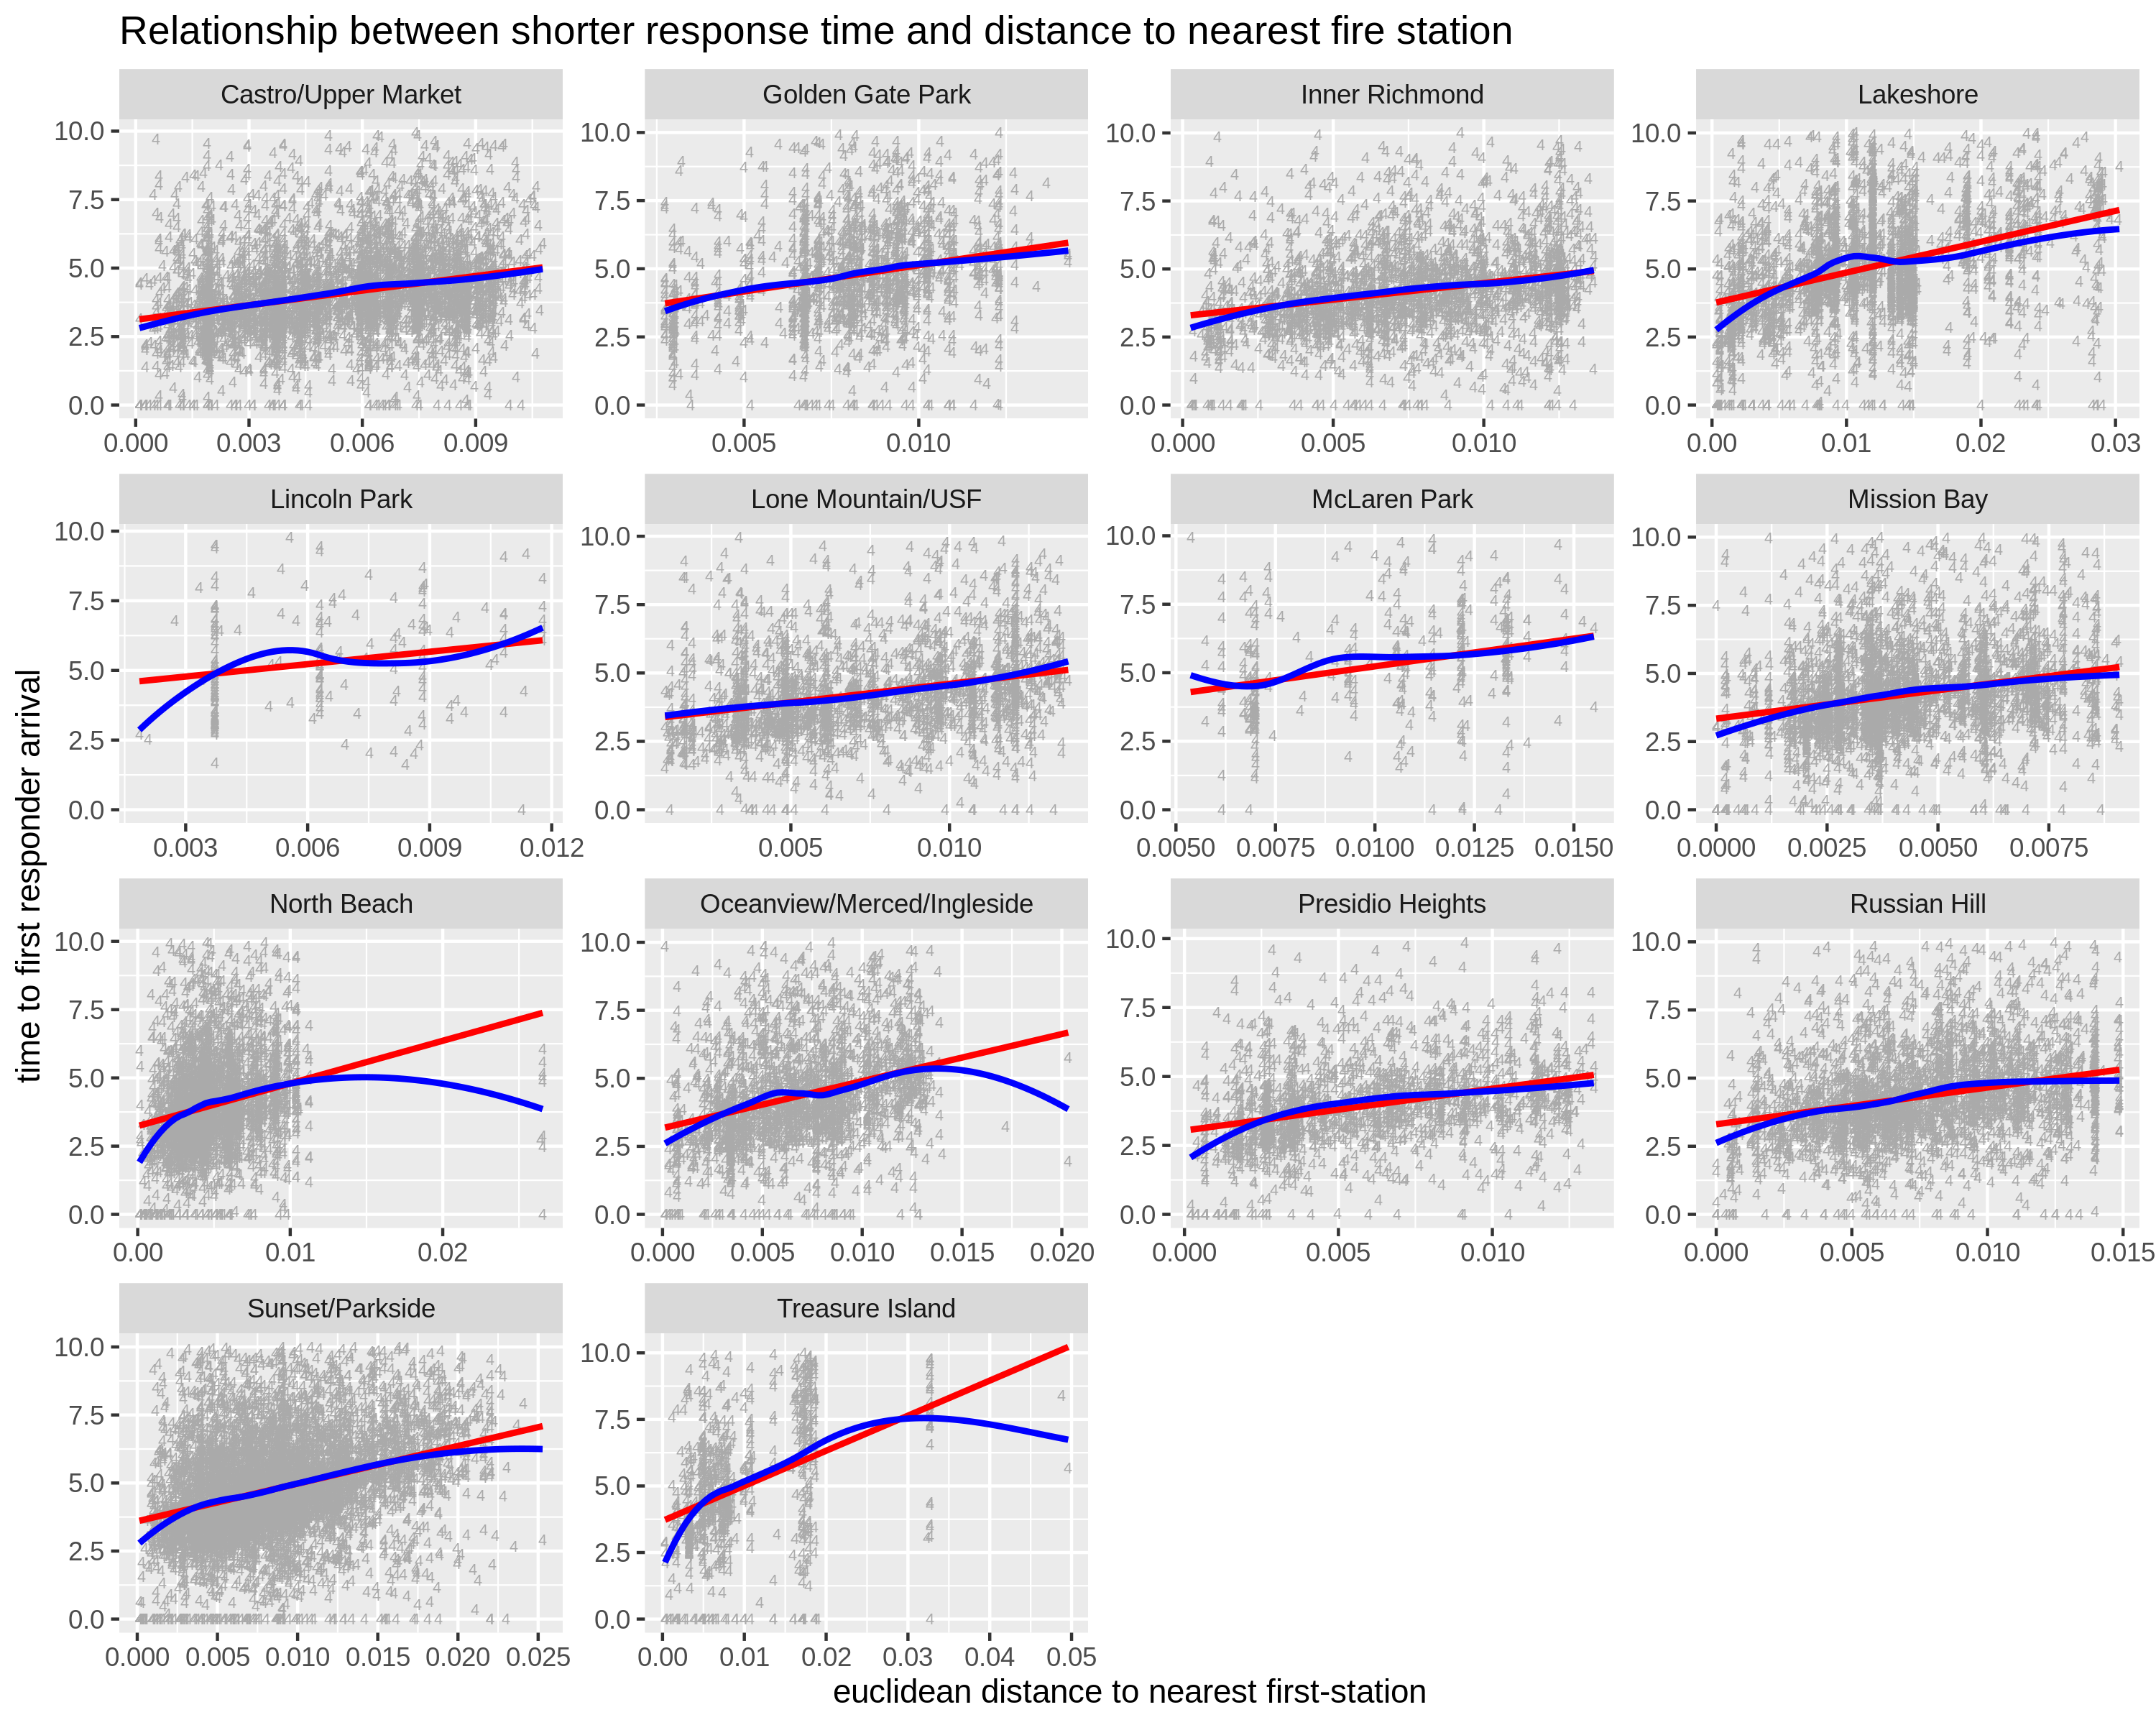

In [94]:
ggplot(group_1_data %>%
        filter(0 <= i_tt_first & i_tt_first <= 10), 
       aes(x=nearest_station, y=i_tt_first)) +
    geom_point(color="#aaaaaa", shape="4") +
    geom_smooth(method='lm', color="red", se=F) +
    geom_smooth(method='loess', color="blue", se=F) +
    facet_wrap(~ neighborhood_district, ncol=4, scales="free") +
    ylab("time to first responder arrival") +
    xlab("euclidean distance to nearest first-station") +
    ggtitle("Relationship between shorter response time and distance to nearest fire station")
    

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



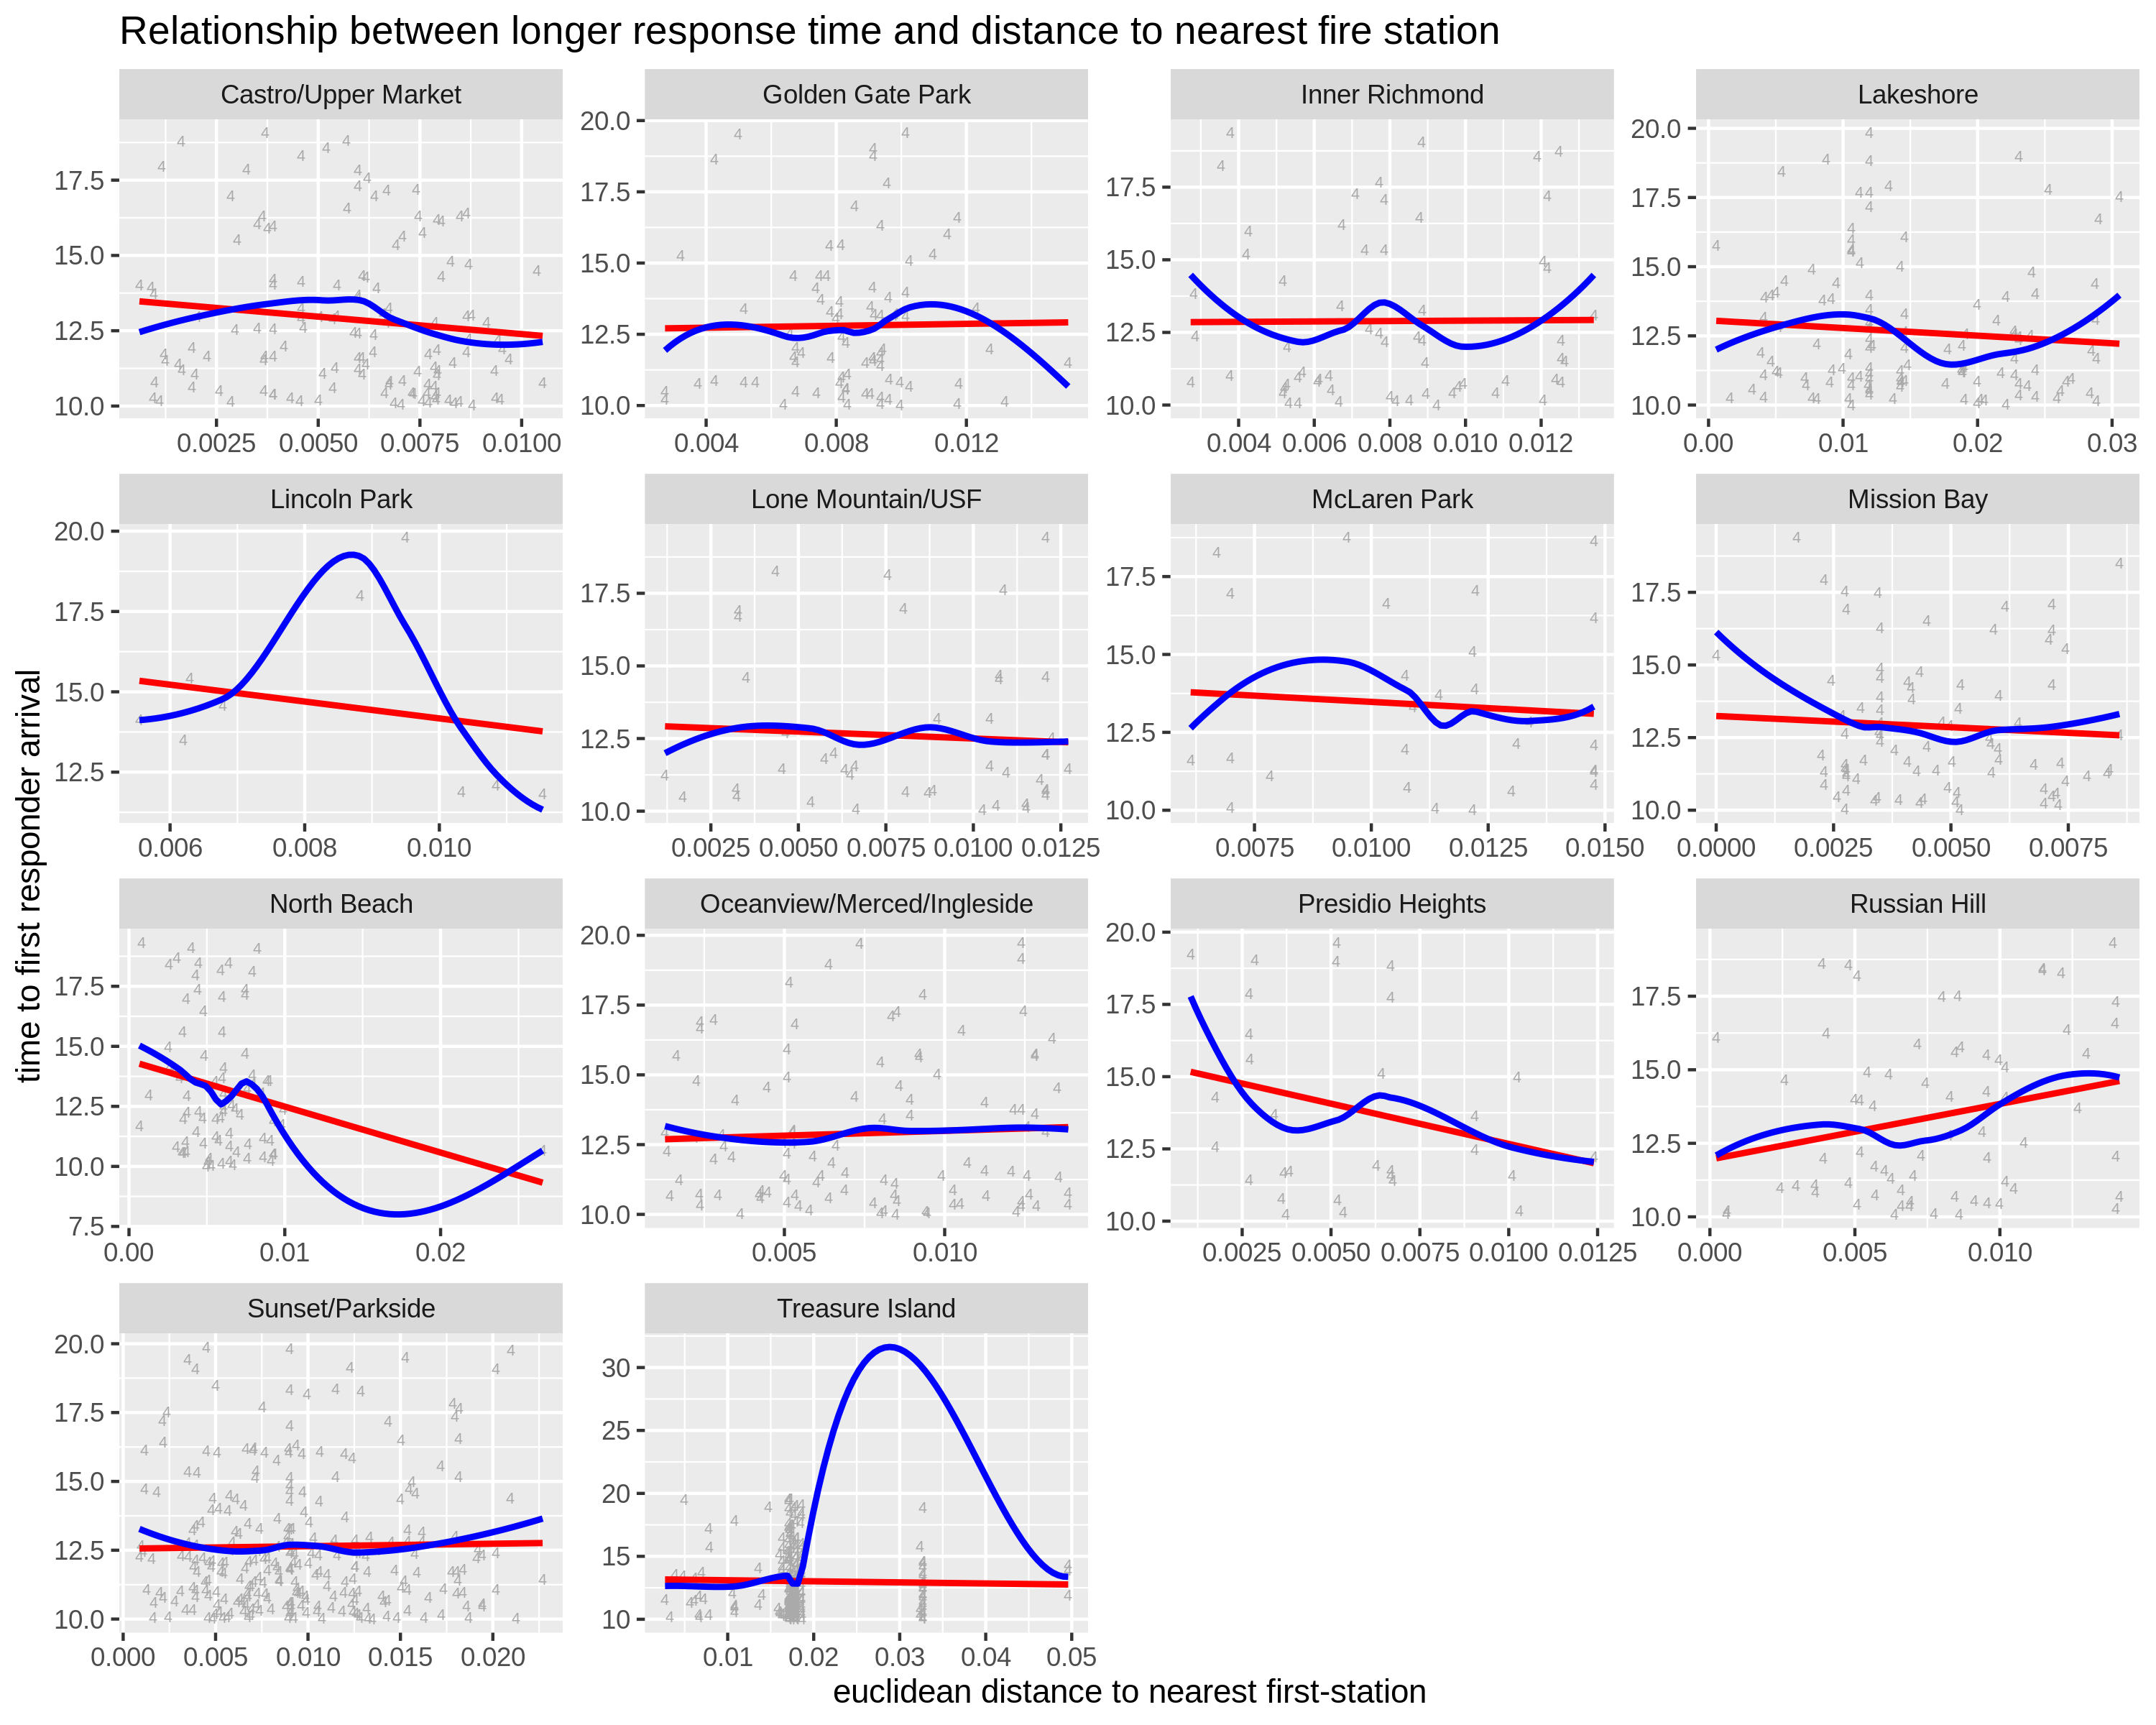

In [95]:
ggplot(group_1_data %>%
        filter(10 <= i_tt_first & i_tt_first <= 20), 
       aes(x=nearest_station, y=i_tt_first)) +
    geom_point(color="#aaaaaa", shape="4") +
    geom_smooth(method='lm', color="red", se=F) +
    geom_smooth(method='loess', color="blue", se=F) +
    facet_wrap(~ neighborhood_district, ncol=4, scales="free") +
    ylab("time to first responder arrival") +
    xlab("euclidean distance to nearest first-station") +
    ggtitle("Relationship between longer response time and distance to nearest fire station")

### Castro/Upper Market deep-dive

In [83]:
castro_upper_market.clean <- group_1_data %>%
    filter(neighborhood_district == "Castro/Upper Market")
    
summary(castro_upper_market.clean)

  incident_id             ID            time_to_first_arrive time_to_last_leave
 Min.   :16001330   Min.   :160013300   Length:4186          Length:4186       
 1st Qu.:17090176   1st Qu.:170901762   Class :difftime      Class :difftime   
 Median :18137878   Median :181378780   Mode  :numeric       Mode  :numeric    
 Mean   :18487864   Mean   :184878644                                          
 3rd Qu.:20042032   3rd Qu.:200420322                                          
 Max.   :21103161   Max.   :211031610                                          
                                                                               
 supervisor_district                    neighborhood_district
 8      :4186        Castro/Upper Market           :4186     
 1      :   0        Bayview Hunters Point         :   0     
 2      :   0        Bernal Heights                :   0     
 3      :   0        Chinatown                     :   0     
 4      :   0        Excelsior                    